In [1]:
import pandas as pd
import csv
import langid
import numpy as np
import requests
import re
import string
import nltk
import unicodedata
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# download the Indonesian stopwords from NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load data
data = pd.read_csv('negative.csv', encoding='utf-8')
print (data)

                                                   text     label
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative
2     Sampai di IKN, asn nya mengeluh...oala disini ...  negative
3     Emang ikn jadi kapan? Kayak dia masih menjabat...  negative
4     Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative
...                                                 ...       ...
8729  Program IKN pertama: Membangun kerjasama denga...  negative
8730  Dirangkul demi menyejahterakan anak-cucu para ...  negative
8731  Rapim TNI-POLRI seharusnya banyak hal lain yan...  negative
8732  Harusnya para gub itu bukan bawa tanah tp bawa...  negative
8733  Siapa bilang kemping di IKN tak ada hasilnya, ...  negative

[8734 rows x 2 columns]


In [4]:
# Cek apakah 'case_folding' ada dalam dataframe
if 'text' in data.columns:
    # Ambil kolom 'case_folding' dari dataframe
    kolom_case_folding = data['text']
    
    # Fungsi untuk memisahkan hashtag
    def pisahkan_hashtag(kalimat):
        # Menggunakan regex untuk mencocokkan pola hashtag
        pola = r'#[A-Za-z0-9_]+'
        hasil = re.findall(pola, kalimat)
        
        # Mengganti hashtag dengan kata terpisah
        for hashtag in hasil:
            kata_terpisah = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
            kalimat = kalimat.replace(hashtag, kata_terpisah)
        
        return kalimat

    # Memisahkan hashtag pada setiap kalimat dalam kolom 'case_folding'
    data['pisah_hashtag&kata'] = kolom_case_folding.apply(pisahkan_hashtag)
    
    # Cetak dataframe untuk memverifikasi hasilnya
    print(data)
else:
    print("Kolom 'case_folding' tidak ada dalam dataframe.")

                                                   text     label  \
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative   
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative   
2     Sampai di IKN, asn nya mengeluh...oala disini ...  negative   
3     Emang ikn jadi kapan? Kayak dia masih menjabat...  negative   
4     Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative   
...                                                 ...       ...   
8729  Program IKN pertama: Membangun kerjasama denga...  negative   
8730  Dirangkul demi menyejahterakan anak-cucu para ...  negative   
8731  Rapim TNI-POLRI seharusnya banyak hal lain yan...  negative   
8732  Harusnya para gub itu bukan bawa tanah tp bawa...  negative   
8733  Siapa bilang kemping di IKN tak ada hasilnya, ...  negative   

                                     pisah_hashtag&kata  
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...

In [5]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil2stem/handling_hashtag.csv", index=False)

In [6]:
data['pisah_hashtag&kata']

0       Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...
1       Belum jadi kok sudah mau memindahkan ASN Pak? ...
2       Sampai di IKN, asn nya mengeluh...oala disini ...
3       Emang ikn jadi kapan? Kayak dia masih menjabat...
4       Tdk semudah itu ASN wajib pindah ke IKN tahun ...
                              ...                        
8729    Program IKN pertama: Membangun kerjasama denga...
8730    Dirangkul demi menyejahterakan anak-cucu para ...
8731    Rapim TNI-POLRI seharusnya banyak hal lain yan...
8732    Harusnya para gub itu bukan bawa tanah tp bawa...
8733    Siapa bilang kemping di IKN tak ada hasilnya, ...
Name: pisah_hashtag&kata, Length: 8734, dtype: object

In [7]:
# Fungsi untuk menghapus tanda baca menggunakan regex
def hapus_tanda_baca(kata):
    return re.sub(r'[^\w\s-]', '', kata)

# Fungsi untuk melakukan preprocessing pada kolom teks
def preprocess_text(text):

    # Menghapus karakter non-ASCII
    text = remove_non_ascii(text)

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)

    # Tokenisasi kalimat menjadi kata-kata
    kata_kata = word_tokenize(text)

    # Menghapus tanda baca dari setiap kata
    kata_kata_tanpa_tanda_baca = [hapus_tanda_baca(kata) for kata in kata_kata]

    # Menggabungkan kata-kata kembali menjadi kalimat
    kalimat_tanpa_tanda_baca = ' '.join(kata_kata_tanpa_tanda_baca)

    # Menggantikan tanda baca dengan spasi tunggal menggunakan regex
    kalimat_final = re.sub(r'(?<=[^\w\s-])', ' ', kalimat_tanpa_tanda_baca)

    # Menggantikan multiple spasi dengan satu spasi menggunakan regex
    kalimat_tanpa_spasi_ganda = re.sub(r'\s+', ' ', kalimat_final)

    # Remove special characters and digits
    kalimat_tanpa_tanda_baca_dan_digit = re.sub(r'[^\w\s-]', '', kalimat_tanpa_spasi_ganda)
    kalimat_tanpa_digit = re.sub(r'\d+', '', kalimat_tanpa_tanda_baca_dan_digit)

    # Convert to lowercase
    kalimat_final = kalimat_tanpa_digit.lower()

    # Remove whitespace leading & trailing
    kalimat_final = kalimat_final.strip()

    # Remove single char
    kalimat_final = re.sub(r"\b[a-zA-Z]\b", "", kalimat_final)

    return kalimat_final

def remove_non_ascii(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

# Melakukan preprocessing pada kolom teks
data['text_cleaning'] = data['pisah_hashtag&kata'].apply(preprocess_text)

In [8]:
import ast

filename = "Final_1.txt"

with open(filename, "r", encoding='utf-8') as file:
    contents = file.read()
    slangs_dict = ast.literal_eval(contents)

print(slangs_dict)

{'tdk': 'tidak', 'jg': 'juga', 'ikn': 'ibu kota negara', 'jd': 'jadi', 'krn': 'karena', 'Bs': 'Bisa', 'Mgkn': 'Mungkin', 'byk': 'banyak', 'thdp': 'terhadap', 'yg': 'yang', 'gpp': 'tidak apa-apa', 'trmsk': 'termasuk', 'bs': 'bisa', 'sm': 'sama', 'msh': 'masih', 'mkn': 'makin', 'g': 'tidak', 'brplah': 'berapalah', 'sdh': 'sudah', 'trus': 'terus', 'ASN': 'Aparatur Sipil Negara', 'gw': 'saya', 'mukin': 'mungkin', 'pling': 'paling', 'gub': 'gubernur', 'blm': 'belum', 'dg': 'dengan', '@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak', 'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa', 'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik', 'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli te

In [9]:
slangs = {r"\b{}\b".format(k): v for k, v in slangs_dict.items()}

data['text_normalisasi'] = data['text_cleaning'].replace(slangs, regex=True)

In [10]:
data['text_normalisasi']

0       lho dia yang minta ibu kota negara kok otorita...
1       belum jadi kok sudah mau memindahkan asn pak y...
2       sampai di ibu kota negara asn nya mengeluh oal...
3       emang ibu kota negara jadi kapan kayak dia mas...
4       tidak semudah itu asn wajib pindah ke ibu kota...
                              ...                        
8729    program ibu kota negara pertama membangun kerj...
8730    dirangkul demi menyejahterakan anak-cucu para ...
8731    rapim tentara nasional indonesia-polri seharus...
8732    harusnya para gubernur itu bukan bawa tanah ta...
8733    siapa bilang kemping di ibu kota negara tidak ...
Name: text_normalisasi, Length: 8734, dtype: object

In [11]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['tweet_tokens'] = data['text_normalisasi'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data['tweet_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0    [lho, dia, yang, minta, ibu, kota, negara, kok...
1    [belum, jadi, kok, sudah, mau, memindahkan, as...
2    [sampai, di, ibu, kota, negara, asn, nya, meng...
3    [emang, ibu, kota, negara, jadi, kapan, kayak,...
4    [tidak, semudah, itu, asn, wajib, pindah, ke, ...
Name: tweet_tokens, dtype: object






In [12]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil2stem/Tweet_all_negative.csv", index=False)

In [13]:
data

,text,label,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens
0,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",negative,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",lho dia yg minta ikn kok otorita di bebani ya ...,lho dia yang minta ibu kota negara kok otorita...,"[lho, dia, yang, minta, ibu, kota, negara, kok..."
1,Belum jadi kok sudah mau memindahkan ASN Pak? ...,negative,Belum jadi kok sudah mau memindahkan ASN Pak? ...,belum jadi kok sudah mau memindahkan asn pak y...,belum jadi kok sudah mau memindahkan asn pak y...,"[belum, jadi, kok, sudah, mau, memindahkan, as..."
2,"Sampai di IKN, asn nya mengeluh...oala disini ...",negative,"Sampai di IKN, asn nya mengeluh...oala disini ...",sampai di ikn asn nya mengeluh oala disini bar...,sampai di ibu kota negara asn nya mengeluh oal...,"[sampai, di, ibu, kota, negara, asn, nya, meng..."
3,Emang ikn jadi kapan? Kayak dia masih menjabat...,negative,Emang ikn jadi kapan? Kayak dia masih menjabat...,emang ikn jadi kapan kayak dia masih menjabat ...,emang ibu kota negara jadi kapan kayak dia mas...,"[emang, ibu, kota, negara, jadi, kapan, kayak,..."
4,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,negative,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,tdk semudah itu asn wajib pindah ke ikn tahun ...,tidak semudah itu asn wajib pindah ke ibu kota...,"[tidak, semudah, itu, asn, wajib, pindah, ke, ..."
...,...,...,...,...,...,...
8729,Program IKN pertama: Membangun kerjasama denga...,negative,Program IKN pertama: Membangun kerjasama denga...,program ikn pertama membangun kerjasama dengan...,program ibu kota negara pertama membangun kerj...,"[program, ibu, kota, negara, pertama, membangu..."
8730,Dirangkul demi menyejahterakan anak-cucu para ...,negative,Dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,"[dirangkul, demi, menyejahterakan, anak-cucu, ..."
8731,Rapim TNI-POLRI seharusnya banyak hal lain yan...,negative,Rapim TNI-POLRI seharusnya banyak hal lain yan...,rapim tni-polri seharusnya banyak hal lain yan...,rapim tentara nasional indonesia-polri seharus...,"[rapim, tentara, nasional, indonesia-polri, se..."
8732,Harusnya para gub itu bukan bawa tanah tp bawa...,negative,Harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gubernur itu bukan bawa tanah ta...,"[harusnya, para, gubernur, itu, bukan, bawa, t..."


In [14]:
data.to_csv("hasil2stem/hasil_preprocessing_negative.csv")

In [16]:
# Memuat data leksikon positif dan negatif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Daftar kata-kata positif dan negatif
positive_words = list(lexicon_positive.keys())
negative_words = list(lexicon_negative.keys())

# Fungsi untuk menentukan polaritas sentimen dari tweet        
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    positive_found = []
    negative_found = []
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
            positive_found.append((word, lexicon_positive[word]))
        if word in lexicon_negative:
            score += lexicon_negative[word]
            negative_found.append((word, lexicon_negative[word]))
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity, positive_found, negative_found

# Asumsi `data` adalah DataFrame yang Anda miliki
# Contoh: data = pd.read_csv('your_input_file.csv')

# Hasil dari menentukan polaritas sentimen dari tweet
results = data['tweet_tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
data['positive_words'] = results[2]
data['negative_words'] = results[3]

# Menyimpan hasil ke file CSV
output_columns = ['tweet_tokens', 'polarity_score', 'polarity', 'positive_words', 'negative_words']

print(data['polarity'].value_counts())


negative    7761
positive     745
neutral      228
Name: polarity, dtype: int64


In [18]:
# Export to csv file
data.to_csv('hasil2stem/Hasil_tweets_negative01.csv', index = False, header = True,index_label=None)

data

,text,label,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens,polarity_score,polarity,positive_words,negative_words
0,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",negative,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",lho dia yg minta ikn kok otorita di bebani ya ...,lho dia yang minta ibu kota negara kok otorita...,"[lho, dia, yang, minta, ibu, kota, negara, kok...",-15,negative,"[(minta, 2)]","[(dia, -3), (yang, -5), (minta, -3), (kota, -1..."
1,Belum jadi kok sudah mau memindahkan ASN Pak? ...,negative,Belum jadi kok sudah mau memindahkan ASN Pak? ...,belum jadi kok sudah mau memindahkan asn pak y...,belum jadi kok sudah mau memindahkan asn pak y...,"[belum, jadi, kok, sudah, mau, memindahkan, as...",0,neutral,"[(jadi, 1), (sudah, 3), (mau, 5), (memindahkan...","[(jadi, -2), (sudah, -2), (mau, -1), (memindah..."
2,"Sampai di IKN, asn nya mengeluh...oala disini ...",negative,"Sampai di IKN, asn nya mengeluh...oala disini ...",sampai di ikn asn nya mengeluh oala disini bar...,sampai di ibu kota negara asn nya mengeluh oal...,"[sampai, di, ibu, kota, negara, asn, nya, meng...",-8,negative,"[(sampai, 2), (kerja, 2), (berdarah, 4), (bias...","[(sampai, -4), (kota, -1), (kena, -3), (tidak,..."
3,Emang ikn jadi kapan? Kayak dia masih menjabat...,negative,Emang ikn jadi kapan? Kayak dia masih menjabat...,emang ikn jadi kapan kayak dia masih menjabat ...,emang ibu kota negara jadi kapan kayak dia mas...,"[emang, ibu, kota, negara, jadi, kapan, kayak,...",-10,negative,"[(jadi, 1), (ada, 4)]","[(kota, -1), (jadi, -2), (kayak, -3), (dia, -3..."
4,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,negative,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,tdk semudah itu asn wajib pindah ke ikn tahun ...,tidak semudah itu asn wajib pindah ke ibu kota...,"[tidak, semudah, itu, asn, wajib, pindah, ke, ...",-15,negative,"[(pindah, 1), (siap, 1), (banget, 1)]","[(tidak, -5), (itu, -2), (wajib, -2), (pindah,..."
...,...,...,...,...,...,...,...,...,...,...
8729,Program IKN pertama: Membangun kerjasama denga...,negative,Program IKN pertama: Membangun kerjasama denga...,program ikn pertama membangun kerjasama dengan...,program ibu kota negara pertama membangun kerj...,"[program, ibu, kota, negara, pertama, membangu...",3,positive,"[(kerja, 2), (sama, 3)]","[(kota, -1), (kota, -1)]"
8730,Dirangkul demi menyejahterakan anak-cucu para ...,negative,Dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,"[dirangkul, demi, menyejahterakan, anak-cucu, ...",2,positive,"[(para, 2), (lewat, 2), (dana, 4)]","[(lewat, -5), (kota, -1)]"
8731,Rapim TNI-POLRI seharusnya banyak hal lain yan...,negative,Rapim TNI-POLRI seharusnya banyak hal lain yan...,rapim tni-polri seharusnya banyak hal lain yan...,rapim tentara nasional indonesia-polri seharus...,"[rapim, tentara, nasional, indonesia-polri, se...",-16,negative,"[(banyak, 3)]","[(banyak, -3), (lain, -4), (yang, -5), (soal, ..."
8732,Harusnya para gub itu bukan bawa tanah tp bawa...,negative,Harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gubernur itu bukan bawa tanah ta...,"[harusnya, para, gubernur, itu, bukan, bawa, t...",-8,negative,"[(para, 2), (bawa, 1), (bawa, 1)]","[(itu, -2), (bukan, -3), (bawa, -3), (bawa, -3..."


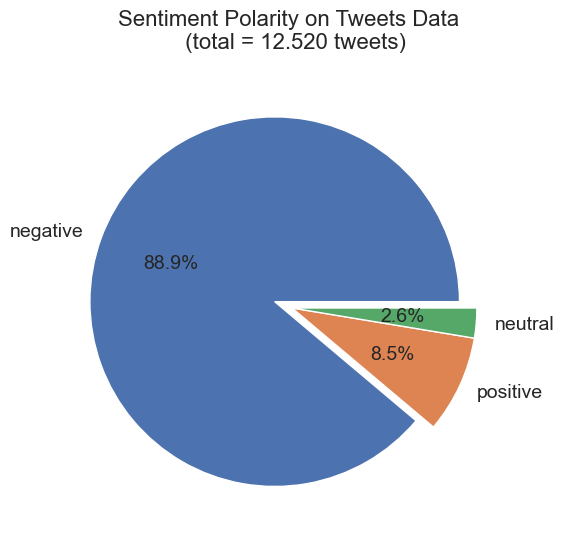

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)
explode = [0.1 if i == 0 else 0 for i in range(len(sizes))]  # set explode values based on index

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 12.520 tweets)', fontsize=16, pad=20)

plt.savefig('hasil2stem/polarity.png')
plt.show()
plt.close()

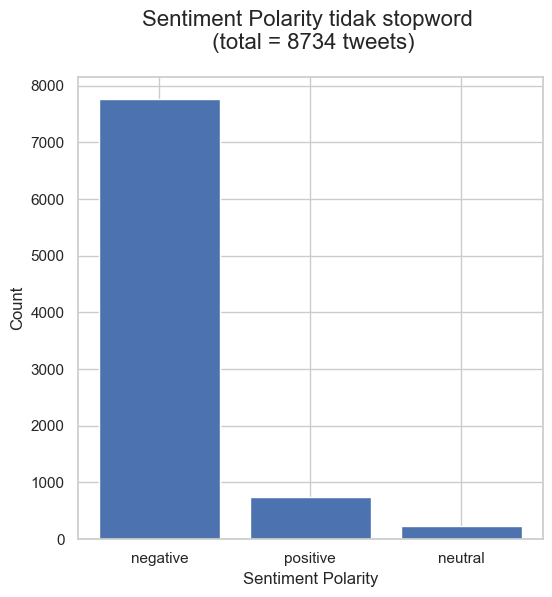

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)

ax.bar(labels, sizes)
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Count')
ax.set_title('Sentiment Polarity tidak stopword \n (total = 8734 tweets)', fontsize=16, pad=20)

plt.savefig('hasil2stem/polarity1.png')
plt.show()
plt.close()

In [21]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets

,text_normalisasi,polarity_score,polarity
1,ibu kota negara belum jadi bos cuman uu nya sudah ada dan disyahkan bagaimana touch si bos ini kayaknya terlalu update infonya makanya kebablasan tertawa tertawa tertawa tertawa tertawa tertawa,30,positive
2,gila ini republik indonesia sama seluruh gubernur kayaknya mau persami di calon ibu kota negara apakah mereka akan menyalakan api unggun lalu menyanyikan lagu api kita sudah menyala api api api api api api kita sudah menyala,23,positive
3,tertawa tertawa tertawa biar ibu kota negara nanti berarti ini kota nantinya dan kota nya bisa di kata-katain tertawa tertawa tertawa kelucuan yang fantastis,22,positive
4,banyak pengamat mengatakan bahwa proyek ibu kota negara akan terbengkalai menurut direktur gerakan perubahan muslim arbi proyek ini kemungkinan akan berakhir seperti rumah hantu jika demikian pasti akan menambah beban negara dan menambah utang lagi,17,positive
5,daripada buat bangun ibu kota negara lebih baik buat kebutuhan pokok rakyat lebih baik buat anggaran guru honorer jadi pegawai negeri sipil lebih baik buat bangun sekolah yang tertinggal lebih baik buat stabilitas harga bahan bakar saudara kita dipapua prnya masih banyak tapi tidak pernah jadi prioritas,16,positive
...,...,...,...
741,aamiin semoga uu ibu kota negara juga dinyatakan inkonstitusi,1,positive
742,wujud asli ibu kota negara nya saja belum ada bagaimana jal emang iknvirtual,1,positive
743,wow metaverse kah ada di ibu kota negara ada di yogya ah ternyata repost,1,positive
744,tidur tidur ibu kota negara sudah mulai dibangun,1,positive


In [22]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = data[data['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_normalisasi,polarity_score,polarity
1,tidak masalah pindah ibu kota jangan saja buat rumah di tanah milik orang apa lagi sertifikat abal yang dungu yang mna coba uda jelas tanah itu milik orang beraninya beli di makelar aduh coba yang dungu yang mna yang pindah ibu kota negara apa yang menyerobot tanah orang mikir jangan dungu dibesarkan,-86,negative
2,wacana periode itu bukan ego minyak goreng mahal bukan ego perebutan lahan rakyat itu bukan ego bahan bakar minyak naik tengah malam itu bukan ego colekcolek dana haji dan jaminan hari tua itu bukan ego yang ego hanya bangun ibu kota negara dan infrastruktur megah bandara internasional dan lain-lain yang lain soal mismanajemen,-68,negative
3,urus minyak goreng bahan bakar minyak saja tidak becus negara indonesia sudah miskin diakibatkan hutang korupsi mafia tanah mafia pajak buzzer harun misi ku dan yang lainnya pindah ibu kota bukan keadaan darurat apalagi membangun ibu kota negara adalah pihak swasta negara harus bayar sewa kepada swasta,-68,negative
4,yang curiga itu tanah dan air yang dibawa wan abud bin kecemplung got ibu kota negara jangan air yang bawa wan abud tanah dn air dari proyek sumur resapan yang bermasalah agar secara simbolis air dn tanah wan abud memancarkan energi negatif yang menggagalkan proyek ibu kota negara,-62,negative
5,tidak kaget kalau sponsor dari jepang mundur dari ibu kota negara nusantara memang dari awal mereka juga tidak cocok dengan pemerintahan jokowi selain karena tekanan publik mereka yang tidak dekat dengan indonesia imbas sakit hati tidak terpilih menjadi bagian kereta cepat jakarta bandung juga salah satunya,-62,negative
6,ada puluhan janji lain yang tidak dipenuhi sampai saat ini itu jauh lebih penting untuk dipenuhi dari pada ibu kota negara kalau sekedar dianggap bikin klimpungan yang pada mau demo faktanya demonstran yang datang dari luar jawa menyewa pesawat bahkan dari luar negeri juga pada bisa datang,-61,negative
7,apa tidak ada perwakilan dari pemerintahjubir untuk berbicara tentang semua yang mnyangkut ibu kota negara dari pada gubernur yang brbicara apa sudah selesai urusan warga yang menolak tanaman bagamna kelanjutan apa kurang kerjaan mengurusi ibu kota negara pasang badan kok soal ritual tapi warga yang tolak tanaman ngk bela,-61,negative
8,yang tidak suka ibu kota negara tahu ibu kota negara itu lambang kesombongan wong tidak pnya uang kok mimpi ketinggian kalau di paksakan rakyatlah yang akn jadi korban karena harus menanggung beban hutang buat sesuatu yang tidak darurat manfaatnya,-60,negative
9,rakyat sedang dicuci otaknya dengan narasi narasi dungu oleh para pejabat csnya semua amburadul akibat ketidak becusan ketidakmampuan rezim ini bekerja mengatasi semua yang ada semua maunya diborong dan tidak satu pun yang memuaskan rakyat dari sembilan bahan pokok sampai ibu kota negara nol,-60,negative
10,kita tidak butuh harapan periode cukup untuk beliau mengobok-obok indonesia menjadi carut marut rakyat tidak butuh pemimpin yang manis di luar kosong di dalam seperti donat tidak butuh ibu kota negara tidak butuh mandalika butuh harga minyak goreng tempe tahu jelas terjangkau,-60,negative


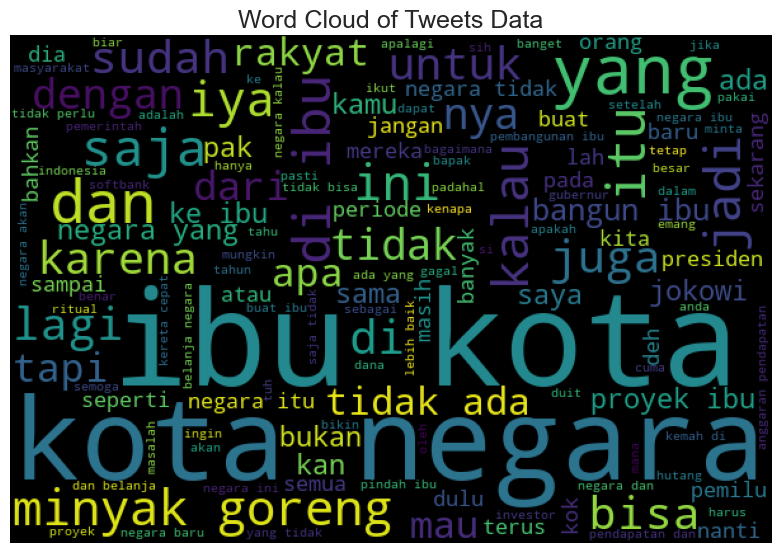

In [23]:
# Visualize word cloud
from wordcloud import WordCloud
list_words=''
for tweet in data['tweet_tokens']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.savefig('hasil2stem/wordcloud.png')
plt.show()

In [24]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

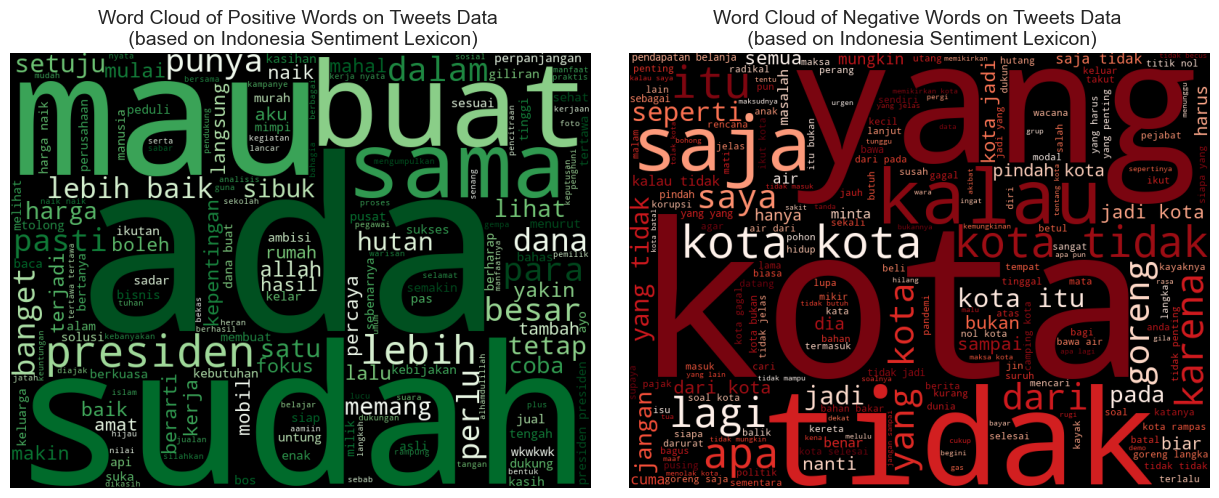

In [25]:
# Visualize positive and negative word cloud

sentiment_words = data['tweet_tokens'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')
plt.savefig('hasil2stem/wordcloud_positif_negatif.png')
plt.show()